# Project 3 - Predicting the Age of Abalone
## Modeling with H2O AutoML

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Data Preprocessing

In [2]:
# Read in unscaled version of the dataset
unscaled_df = pd.read_csv('./Dataset/abalone_unscaled_data.csv')
unscaled_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age
0,M,91,73,19,102.8,44.9,20.2,30.0,15,16.5
1,M,70,53,18,45.1,19.9,9.7,14.0,7,8.5
2,F,106,84,27,135.4,51.3,28.3,42.0,9,10.5
3,M,88,73,25,103.2,43.1,22.8,31.0,10,11.5
4,I,66,51,16,41.0,17.9,7.9,11.0,7,8.5


In [3]:
unscaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   int64  
 2   Diameter        4177 non-null   int64  
 3   Height          4177 non-null   int64  
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
 9   Age             4177 non-null   float64
dtypes: float64(5), int64(4), object(1)
memory usage: 326.5+ KB


In [4]:
orig_df = unscaled_df.copy()

In [5]:
# Label Encode the categorical "Sex" column
# Note: Female => 0
#       Infant => 1
#       Male   => 2
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
unscaled_df['Sex_LabelEncoded'] = le.fit_transform(unscaled_df['Sex'])
unscaled_df.head()


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_LabelEncoded
0,M,91,73,19,102.8,44.9,20.2,30.0,15,16.5,2
1,M,70,53,18,45.1,19.9,9.7,14.0,7,8.5,2
2,F,106,84,27,135.4,51.3,28.3,42.0,9,10.5,0
3,M,88,73,25,103.2,43.1,22.8,31.0,10,11.5,2
4,I,66,51,16,41.0,17.9,7.9,11.0,7,8.5,1


In [6]:
# Binary encode the categorical "Sex" column
unscaled_df = pd.get_dummies(unscaled_df, prefix=['Sex'], columns=['Sex'])
unscaled_df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Sex_LabelEncoded,Sex_F,Sex_I,Sex_M
0,91,73,19,102.8,44.9,20.2,30.0,15,16.5,2,0,0,1
1,70,53,18,45.1,19.9,9.7,14.0,7,8.5,2,0,0,1
2,106,84,27,135.4,51.3,28.3,42.0,9,10.5,0,1,0,0
3,88,73,25,103.2,43.1,22.8,31.0,10,11.5,2,0,0,1
4,66,51,16,41.0,17.9,7.9,11.0,7,8.5,1,0,1,0


In [7]:
# Reorganize columns
column_order = ["Sex_LabelEncoded", "Sex_M", "Sex_F", "Sex_I", "Length", 
                "Diameter", "Height", "Whole_weight", "Shucked_weight", 
                "Viscera_weight", "Shell_weight", "Rings", "Age"]
unscaled_df = unscaled_df.reindex(columns=column_order)
unscaled_df.head()

,Sex_LabelEncoded,Sex_M,Sex_F,Sex_I,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age
0,2,1,0,0,91,73,19,102.8,44.9,20.2,30.0,15,16.5
1,2,1,0,0,70,53,18,45.1,19.9,9.7,14.0,7,8.5
2,0,0,1,0,106,84,27,135.4,51.3,28.3,42.0,9,10.5
3,2,1,0,0,88,73,25,103.2,43.1,22.8,31.0,10,11.5
4,1,0,0,1,66,51,16,41.0,17.9,7.9,11.0,7,8.5


In [8]:
# Binning the Rings column
unscaled_df['Rings_Bin']=pd.cut(unscaled_df['Rings'], bins=6, labels=False)

In [9]:
# Display the cross-reference between Rings and Rings_Bin
xref_df = unscaled_df.copy()
xref_df = xref_df[["Rings", "Rings_Bin"]]
xref_df.drop_duplicates().sort_values(by=['Rings'])


,Rings,Rings_Bin
236,1,0
719,2,0
237,3,0
44,4,0
42,5,0
48,6,1
1,7,1
5,8,1
2,9,1
3,10,1


In [10]:
unscaled_df.head()

,Sex_LabelEncoded,Sex_M,Sex_F,Sex_I,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Age,Rings_Bin
0,2,1,0,0,91,73,19,102.8,44.9,20.2,30.0,15,16.5,2
1,2,1,0,0,70,53,18,45.1,19.9,9.7,14.0,7,8.5,1
2,0,0,1,0,106,84,27,135.4,51.3,28.3,42.0,9,10.5,1
3,2,1,0,0,88,73,25,103.2,43.1,22.8,31.0,10,11.5,1
4,1,0,0,1,66,51,16,41.0,17.9,7.9,11.0,7,8.5,1


## Prep dataframe for AutoML

In [11]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/t5/qwwd_0x916z26lhlsjz8bq_40000gn/T/tmpn4f_6x82
  JVM stdout: /var/folders/t5/qwwd_0x916z26lhlsjz8bq_40000gn/T/tmpn4f_6x82/h2o_stevenlee_started_from_python.out
  JVM stderr: /var/folders/t5/qwwd_0x916z26lhlsjz8bq_40000gn/T/tmpn4f_6x82/h2o_stevenlee_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_stevenlee_9s5u4r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"accepting new members, healthy"


In [30]:
h2o_df = unscaled_df.copy()

## Choose Combination of Sex LabelEncoded/One-Hot-Encoded and Rings with/without Bins

In [ ]:
# Use Sex LabelEncoded and Rings Without Bins
h2o_df.drop(['Sex_M', 'Sex_F', 'Sex_I', 'Age', 'Rings_Bin'], axis=1, inplace=True)
h2o_df.head()

In [ ]:
# Use Sex LabelEncoded and Rings_Bin
h2o_df.drop(['Sex_M', 'Sex_F', 'Sex_I', 'Age', 'Rings'], axis=1, inplace=True)
h2o_df.head()

In [13]:
# Use Sex One-Hot-Encoded and Rings Without Bins
h2o_df.drop(['Sex_LabelEncoded', 'Age', 'Rings_Bin'], axis=1, inplace=True)
h2o_df.head()

,Sex_M,Sex_F,Sex_I,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,1,0,0,91,73,19,102.8,44.9,20.2,30.0,15
1,1,0,0,70,53,18,45.1,19.9,9.7,14.0,7
2,0,1,0,106,84,27,135.4,51.3,28.3,42.0,9
3,1,0,0,88,73,25,103.2,43.1,22.8,31.0,10
4,0,0,1,66,51,16,41.0,17.9,7.9,11.0,7


In [31]:
# Use Sex One-Hot-Encoded and Rings_Bin
h2o_df.drop(['Sex_LabelEncoded', 'Age', 'Rings'], axis=1, inplace=True)
h2o_df.head()

,Sex_M,Sex_F,Sex_I,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings_Bin
0,1,0,0,91,73,19,102.8,44.9,20.2,30.0,2
1,1,0,0,70,53,18,45.1,19.9,9.7,14.0,1
2,0,1,0,106,84,27,135.4,51.3,28.3,42.0,1
3,1,0,0,88,73,25,103.2,43.1,22.8,31.0,1
4,0,0,1,66,51,16,41.0,17.9,7.9,11.0,1


## Create H2OFrame

In [32]:
# Create H2O frame from a pandas dataframe
h2oframe = h2o.H2OFrame(h2o_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Train-Test-Split

In [33]:
splits = h2oframe.split_frame(ratios=[0.8], seed=1)
train = splits[0]
test = splits[1]

## Set Categorical columns to Enums

In [ ]:
# Change categorical columns to enums
# For Sex_Label_Encoded and Rings without Bins
train['Sex_LabelEncoded_cat'] = train['Sex_LabelEncoded'].asfactor()
train.pop('Sex_LabelEncoded')
train['Rings_cat'] = train['Rings'].asfactor()
train.pop('Rings')

test['Sex_LabelEncoded_cat'] = test['Sex_LabelEncoded'].asfactor()
test.pop('Sex_LabelEncoded')
test['Rings_cat'] = test['Rings'].asfactor()
test.pop('Rings')

In [ ]:
# Change categorical columns to enums
# For Sex_Label_Encoded and Rings with Bins
train['Sex_LabelEncoded_cat'] = train['Sex_LabelEncoded'].asfactor()
train.pop('Sex_LabelEncoded')
train['Rings_Bin_cat'] = train['Rings_Bin'].asfactor()
train.pop('Rings_Bin')

test['Sex_LabelEncoded_cat'] = test['Sex_LabelEncoded'].asfactor()
test.pop('Sex_LabelEncoded')
test['Rings_Bin_cat'] = test['Rings_Bin'].asfactor()
test.pop('Rings_Bin')

In [16]:
# Change categorical columns to enums
# For Sex One-Hot-Encoded and Rings without Bins
train['Sex_M_cat'] = train['Sex_M'].asfactor()
train.pop('Sex_M')
train['Sex_F_cat'] = train['Sex_F'].asfactor()
train.pop('Sex_F')
train['Sex_I_cat'] = train['Sex_I'].asfactor()
train.pop('Sex_I')
train['Rings_cat'] = train['Rings'].asfactor()
train.pop('Rings')

test['Sex_M_cat'] = test['Sex_M'].asfactor()
test.pop('Sex_M')
test['Sex_F_cat'] = test['Sex_F'].asfactor()
test.pop('Sex_F')
test['Sex_I_cat'] = test['Sex_I'].asfactor()
test.pop('Sex_I')
test['Rings_cat'] = test['Rings'].asfactor()
test.pop('Rings')

Rings
9
19
11
8
9
7
8
7
8
20


In [34]:
# Change categorical columns to enums
# For Sex One-Hot-Encoded an Rings with Bins
train['Sex_M_cat'] = train['Sex_M'].asfactor()
train.pop('Sex_M')
train['Sex_F_cat'] = train['Sex_F'].asfactor()
train.pop('Sex_F')
train['Sex_I_cat'] = train['Sex_I'].asfactor()
train.pop('Sex_I')
train['Rings_Bin_cat'] = train['Rings_Bin'].asfactor()
train.pop('Rings_Bin')

test['Sex_M_cat'] = test['Sex_M'].asfactor()
test.pop('Sex_M')
test['Sex_F_cat'] = test['Sex_F'].asfactor()
test.pop('Sex_F')
test['Sex_I_cat'] = test['Sex_I'].asfactor()
test.pop('Sex_I')
test['Rings_Bin_cat'] = test['Rings_Bin'].asfactor()
test.pop('Rings_Bin')

Rings_Bin
1
3
2
1
1
1
1
1
1
4


In [35]:
train.describe()

Rows:3356
Cols:11




,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_M_cat,Sex_F_cat,Sex_I_cat,Rings_Bin_cat
type,int,int,int,real,real,real,real,enum,enum,enum,enum
mins,15.0,11.0,0.0,0.4,0.2,0.1,0.3,,,,
mean,104.67878426698462,81.47556615017872,27.865911799761644,165.0129618593561,71.6634386174015,35.92246722288453,47.54910607866504,,,,
maxs,163.0,130.0,226.0,565.1,297.6,128.3,201.0,,,,
sigma,23.88889913889918,19.766000678914363,8.483343200993328,97.49024750974279,44.106202827318036,21.736061131072233,27.77401613694054,,,,
zeros,0,0,2,0,0,0,0,,,,
missing,0,0,0,0,0,0,0,0,0,0,0
0,91.0,73.0,19.0,102.8,44.9,20.2,30.0,1,0,0,2
1,70.0,53.0,18.0,45.1,19.9,9.7,14.0,1,0,0,1
2,88.0,73.0,25.0,103.2,43.1,22.8,31.0,1,0,0,1


## Set X and y

In [18]:
# Set X and y for:
# Rings without Bins
X = train.columns
y = 'Rings_cat'
X.remove(y)

In [36]:
# Set X and y for:
# Rings with Bins
X = train.columns
y = 'Rings_Bin_cat'
X.remove(y)

## Run AutoML Model

In [37]:
aml = H2OAutoML(max_runtime_secs=120, seed=1)
aml.train(x=X, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [38]:
# Save leaderboard output to CSV
lb = aml.leaderboard
output_df = lb.as_data_frame()
output_df.to_csv("output4.csv")

## Analyze performance

In [39]:
# View the leaderboard
#h2o.automl.get_leaderboard(aml, extra_columns='all')
lb = aml.leaderboard
lb.head(rows = lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse
XGBoost_grid__1_AutoML_20200814_143213_model_1,0.643901,0.755554,0.481447,0.231792
XGBoost_grid__1_AutoML_20200814_143213_model_9,0.644229,0.74886,0.486116,0.236309
XGBoost_grid__1_AutoML_20200814_143213_model_4,0.645976,0.811677,0.486751,0.236926
XGBoost_grid__1_AutoML_20200814_143213_model_3,0.646448,0.775972,0.492768,0.242821
XGBoost_1_AutoML_20200814_143213,0.646582,0.761868,0.49019,0.240286
GBM_5_AutoML_20200814_143213,0.647267,0.71788,0.489623,0.239731
XGBoost_3_AutoML_20200814_143213,0.647872,0.726002,0.480801,0.231169
GBM_4_AutoML_20200814_143213,0.649747,0.755362,0.491062,0.241142
XGBoost_grid__1_AutoML_20200814_143213_model_7,0.649756,0.743223,0.482598,0.232901
XGBoost_grid__1_AutoML_20200814_143213_model_2,0.65152,0.713182,0.482466,0.232773


In [40]:
# View details of the leader
perf = aml.leader.model_performance(test)
perf


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.22549810879847493
RMSE: 0.47486641152904774
LogLoss: 0.7111811854976323
Mean Per-Class Error: 0.4588678885070638

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,26.0,10.0,0.0,0.0,0.0,0.0,0.277778,10 / 36
1,8.0,408.0,67.0,2.0,0.0,0.0,0.158763,77 / 485
2,0.0,109.0,129.0,10.0,4.0,0.0,0.488095,123 / 252
3,0.0,8.0,21.0,6.0,0.0,0.0,0.828571,29 / 35
4,0.0,0.0,11.0,2.0,0.0,0.0,1.000000,13 / 13
5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
6,34.0,535.0,228.0,20.0,4.0,0.0,0.306943,252 / 821



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.693057
1,2,0.945189
2,3,0.985384
3,4,1.000000
4,5,1.000000
5,6,1.000000


In [41]:
aml.leader.r2(test)

0.8265740309123815

In [42]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20200814_143213_model_1


Model Summary: 


,,number_of_trees
0,,42.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.09018489584316236
RMSE: 0.3003080016302635
LogLoss: 0.30609608259619747
Mean Per-Class Error: 0.07196626372539104

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,147.0,6.0,0.0,0.0,0.0,0.0,0.039216,6 / 153
1,2.0,1992.0,61.0,1.0,0.0,0.0,0.031128,"64 / 2,056"
2,0.0,218.0,716.0,0.0,0.0,0.0,0.233405,218 / 934
3,0.0,3.0,18.0,143.0,0.0,0.0,0.128049,21 / 164
4,0.0,0.0,0.0,0.0,44.0,0.0,0.000000,0 / 44
5,0.0,0.0,0.0,0.0,0.0,5.0,0.000000,0 / 5
6,149.0,2219.0,795.0,144.0,44.0,5.0,0.092074,"309 / 3,356"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.907926
1,2,0.998510
2,3,1.000000
3,4,1.000000
4,5,1.000000
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.23179161989749053
RMSE: 0.4814474217372968
LogLoss: 0.7555544747905787
Mean Per-Class Error: 0.6439005744540364

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,89.0,64.0,0.0,0.0,0.0,0.0,0.418301,64 / 153
1,25.0,1742.0,278.0,8.0,3.0,0.0,0.152724,"314 / 2,056"
2,0.0,447.0,459.0,25.0,3.0,0.0,0.508565,475 / 934
3,0.0,31.0,103.0,28.0,1.0,1.0,0.829268,136 / 164
4,0.0,4.0,28.0,10.0,2.0,0.0,0.954545,42 / 44
5,0.0,0.0,3.0,1.0,1.0,0.0,1.000000,5 / 5
6,114.0,2288.0,871.0,72.0,10.0,1.0,0.308701,"1,036 / 3,356"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.691299
1,2,0.938617
2,3,0.983015
3,4,0.997616
4,5,0.999702
5,6,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.69130343,0.010123006,0.6770833,0.6989568,0.69299555,0.7019374,0.68554395
1,err,0.3086966,0.010123006,0.32291666,0.3010432,0.30700448,0.2980626,0.31445605
2,err_count,207.2,6.9065185,217.0,202.0,206.0,200.0,211.0
3,logloss,0.7555474,0.030576397,0.77937424,0.78689575,0.7091759,0.75142395,0.75086707
4,max_per_class_error,0.9692308,0.06880209,1.0,0.84615386,1.0,1.0,1.0
5,mean_per_class_accuracy,0.4197054,0.11687759,0.31918406,0.5568163,0.33627534,0.5371468,0.34910443
6,mean_per_class_error,0.5802946,0.11687759,0.68081594,0.44318372,0.66372466,0.4628532,0.65089554
7,mse,0.23178916,0.005481806,0.24006781,0.22532767,0.22922453,0.23092648,0.23339926
8,r2,0.55310327,0.020628348,0.5693884,0.54396737,0.55308414,0.57530665,0.52376974
9,rmse,0.48141807,0.0056793434,0.48996717,0.47468692,0.47877398,0.4805481,0.48311412



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
0,,2020-08-14 14:32:41,1.470 sec,0.0,0.833333,1.791759,0.721692
1,,2020-08-14 14:32:41,1.541 sec,5.0,0.541125,0.802904,0.248212
2,,2020-08-14 14:32:41,1.604 sec,10.0,0.448595,0.586227,0.221395
3,,2020-08-14 14:32:41,1.666 sec,15.0,0.406253,0.495335,0.193683
4,,2020-08-14 14:32:41,1.730 sec,20.0,0.378604,0.439870,0.168951
5,,2020-08-14 14:32:41,1.794 sec,25.0,0.359113,0.402115,0.152265
6,,2020-08-14 14:32:42,1.860 sec,30.0,0.339641,0.368844,0.129321
7,,2020-08-14 14:32:42,1.926 sec,35.0,0.323191,0.342124,0.113528
8,,2020-08-14 14:32:42,1.995 sec,40.0,0.306940,0.316372,0.100417
9,,2020-08-14 14:32:42,2.028 sec,42.0,0.300308,0.306096,0.092074



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Shell_weight,1743.081665,1.000000,0.221359
1,Shucked_weight,1163.974487,0.667768,0.147816
2,Whole_weight,1065.398804,0.611216,0.135298
3,Diameter,1060.281372,0.608280,0.134648
4,Height,968.470642,0.555608,0.122989
5,Viscera_weight,927.612000,0.532168,0.117800
6,Length,659.240234,0.378204,0.083719
7,Sex_I_cat.0,136.509674,0.078315,0.017336
8,Sex_F_cat.0,61.546261,0.035309,0.007816
9,Sex_M_cat.0,46.305054,0.026565,0.005880


## Analyze predictions

In [43]:
y_pred = aml.predict(test)
y_pred2 = y_pred['predict'].as_data_frame()
y_pred2 = y_pred2['predict'].to_list()

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [27]:
# For Rings not in Bins
test_temp = test['Rings_cat'].as_data_frame()
test_temp = test_temp['Rings_cat'].to_list()

In [44]:
# For Rings in Bins
test_temp = test['Rings_Bin_cat'].as_data_frame()
test_temp = test_temp['Rings_Bin_cat'].to_list()

In [45]:
# Create dataframe of predictions vs test
act_v_pred_df = pd.DataFrame({'Actual':test_temp, 'Predicted':y_pred2})
act_v_pred_df

,Actual,Predicted
0,1,1
1,3,3
2,2,1
3,1,1
4,1,1
...,...,...
816,2,3
817,1,0
818,1,1
819,1,2


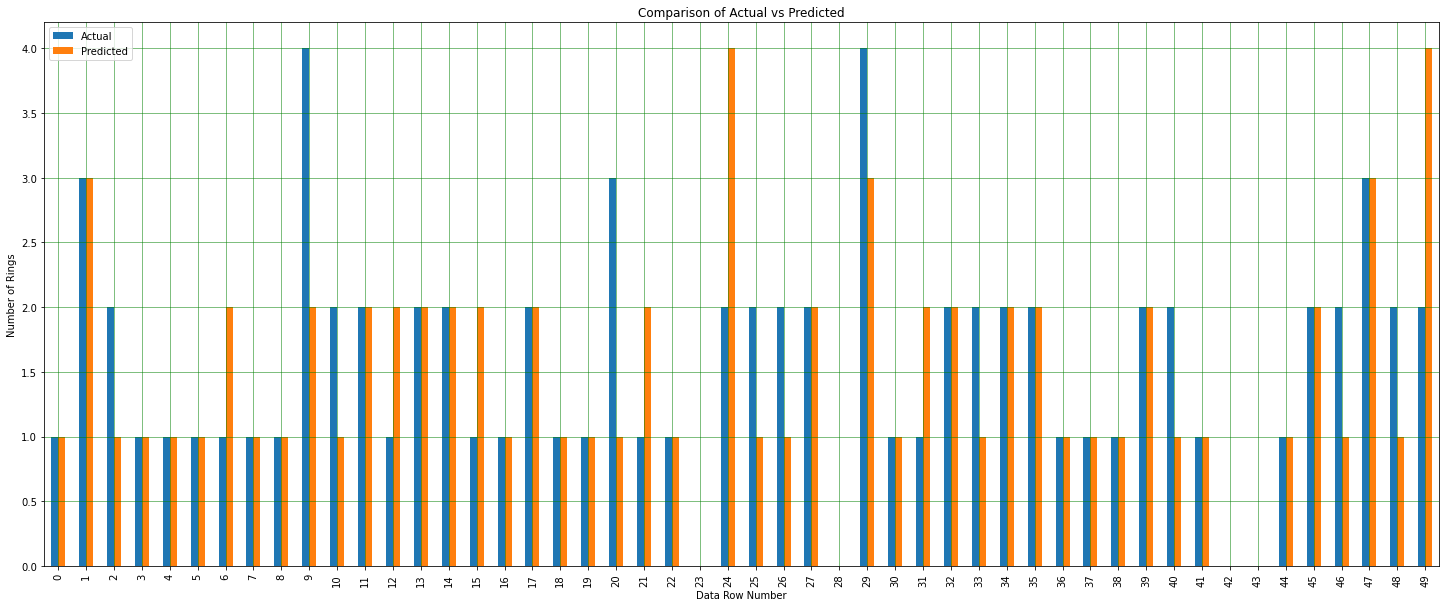

In [56]:
# Create graph of predictions vs test
act_v_pred_plot_df = act_v_pred_df[:50]
act_v_pred_plot_df.plot(kind='bar',figsize=(25,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Comparison of Actual vs Predicted")
plt.xlabel("Data Row Number")
plt.ylabel("Number of Rings")

plt.savefig("output4.png")
plt.show()

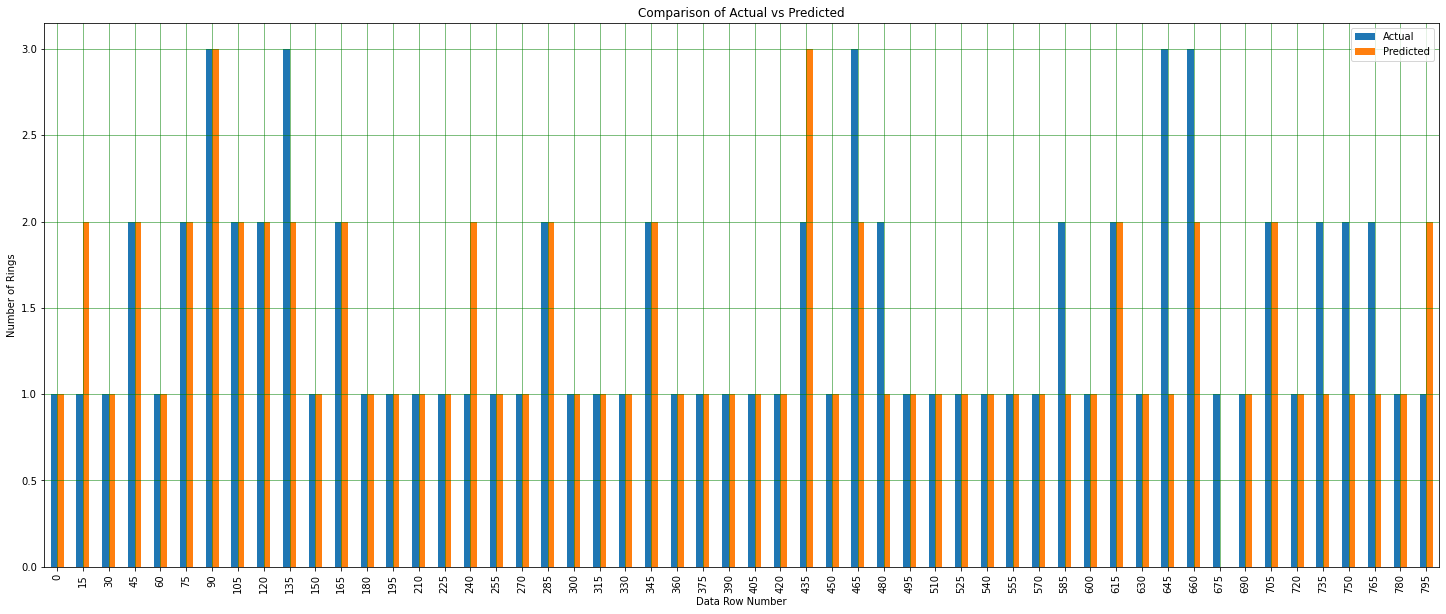

In [62]:
# Create graph of predictions vs test
act_v_pred_plot_df = act_v_pred_df[:800:15]
act_v_pred_plot_df.plot(kind='bar',figsize=(25,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Comparison of Actual vs Predicted")
plt.xlabel("Data Row Number")
plt.ylabel("Number of Rings")

plt.savefig("output4b.png")
plt.show()

In [ ]:
# Close cluster
h2o.cluster().shutdown()